In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import EllipticBitcoinDataset
from torch_geometric.nn import SAGEConv
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

d:\DL Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device('cpu')
print(f'Using device: {DEVICE}')

Using device: cpu


In [3]:
dataset = EllipticBitcoinDataset(root='./dataset')
data = dataset[0].to(DEVICE)
print(data)

Data(x=[203769, 165], edge_index=[2, 234355], y=[203769], train_mask=[203769], test_mask=[203769])


In [4]:
data.edge_index = data.edge_index.to(torch.long)  
mask = data.y != -1
labels = data.y.clone()

In [5]:
from sklearn.model_selection import train_test_split
mask_idx = mask.nonzero(as_tuple=True)[0]
train_idx, test_idx = train_test_split(mask_idx.cpu(), test_size=0.3, stratify=labels[mask].cpu(), random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=labels[test_idx].cpu(), random_state=42)

In [6]:
train_labels = labels[train_idx]
class_counts = torch.bincount(train_labels)

In [7]:
from torch.nn import CrossEntropyLoss

class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum() * len(class_counts)
print("Class weights:", class_weights)

# Cross-entropy with weights
ce_loss_fn = CrossEntropyLoss(weight=class_weights)

Class weights: tensor([0.2854, 2.6383, 0.0763])


In [8]:
class GraphSAGEEncoder(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hid_dim)
        self.conv2 = SAGEConv(hid_dim, out_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        z = self.conv2(x, edge_index)
        return z

In [9]:
class SAGEClassifier(nn.Module):
    def __init__(self, encoder, num_classes, dropout=0.3):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.conv2.out_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)            
        logits = self.classifier(F.dropout(z, p=self.dropout, training=self.training))
        return logits, z

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

def evaluate_model(model, data, test_idx, labels, name, metrics_store):
    model.eval()
    with torch.no_grad():
        logits, _ = model(data.x, data.edge_index)
        preds = logits.argmax(dim=1)[test_idx].cpu()
        y_true = labels[test_idx].cpu()

    precision = precision_score(y_true, preds, average='macro', zero_division=0)
    recall = recall_score(y_true, preds, average='macro', zero_division=0)
    f1 = f1_score(y_true, preds, average='macro', zero_division=0)
    acc = accuracy_score(y_true, preds)
    report = classification_report(y_true, preds, output_dict=True, zero_division=0)

    # Save metrics
    metrics_store[name] = {
        "precision": round(precision, 4),
        "recall": round(recall, 4),
        "f1": round(f1, 4),
        "accuracy": round(acc, 4),
        "per_class_report": report
    }

    print(f"✅ {name} Model Results:")
    print(f"  Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Accuracy: {acc:.4f}\n")
    print(f"  Per-Class Report:")
    for class_label, metrics in report.items():
        if class_label == "accuracy":
            continue
        print(f"    Class {class_label}: Precision: {metrics['precision']:.4f} | Recall: {metrics['recall']:.4f} | F1: {metrics['f1-score']:.4f}")
    return preds
metrics_data = {}

In [11]:
#Hyperparams
in_dim = data.x.size(1)
hid_dim = 128
emb_dim = 64
num_classes = 3   
lr = 0.01
weight_decay = 5e-4
epochs = 100
lambda_recon = 0.1

In [12]:
encoder = GraphSAGEEncoder(in_dim, hid_dim, emb_dim, dropout=0.3).to(DEVICE)
model_weighted = SAGEClassifier(encoder, num_classes, dropout=0.3).to(DEVICE)
optimizer = torch.optim.Adam(model_weighted.parameters(), lr=lr, weight_decay=weight_decay)

In [13]:
def recon_loss_from_z(z, edge_index):
    row, col = edge_index
    pos_scores = (z[row] * z[col]).sum(dim=1)
    return -torch.log(torch.sigmoid(pos_scores) + 1e-8).mean()

In [14]:
epochs = 100
train_accs, val_accs = [], []

for epoch in range(1, epochs + 1):
    # === TRAIN ===
    model_weighted.train()
    optimizer.zero_grad()

    logits, z_all = model_weighted(data.x, data.edge_index)  # logits: [N, num_classes]

    # select only train nodes (labels 0, 1, or 2)
    loss_ce = ce_loss_fn(logits[train_idx], labels[train_idx])
    rloss = recon_loss_from_z(z_all, data.edge_index) if lambda_recon > 0 else torch.tensor(0.0, device=DEVICE)

    loss = loss_ce + lambda_recon * rloss
    loss.backward()
    optimizer.step()

    # compute training accuracy
    with torch.no_grad():
        preds_train = logits[train_idx].argmax(dim=1).cpu()
        true_train = labels[train_idx].cpu()
        train_acc = (preds_train == true_train).float().mean().item()

    # === VALIDATION ===
    if epoch % 5 == 0 or epoch == 1:
        model_weighted.eval()
        with torch.no_grad():
            logits_eval, _ = model_weighted(data.x, data.edge_index)
            preds_val = logits_eval[val_idx].argmax(dim=1).cpu()
            true_val = labels[val_idx].cpu()
            val_acc = (preds_val == true_val).float().mean().item()

        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | CE: {loss_ce.item():.4f} | Recon: {rloss.item():.4f}")
        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        print("Val known metrics:")
        print(classification_report(true_val, preds_val, target_names=['licit(0)','illicit(1)','unknown(2)'], zero_division=0))

        train_accs.append(train_acc)
        val_accs.append(val_acc)

Epoch 001 | Loss: 1.1392 | CE: 1.1208 | Recon: 0.1841
Train Acc: 0.5745 | Val Acc: 0.2079
Val known metrics:
              precision    recall  f1-score   support

    licit(0)       0.21      1.00      0.34      6303
  illicit(1)       0.42      0.08      0.14       681
  unknown(2)       1.00      0.00      0.00     23581

    accuracy                           0.21     30565
   macro avg       0.54      0.36      0.16     30565
weighted avg       0.82      0.21      0.07     30565

Epoch 005 | Loss: 0.8832 | CE: 0.8809 | Recon: 0.0231
Train Acc: 0.6930 | Val Acc: 0.6386
Val known metrics:
              precision    recall  f1-score   support

    licit(0)       0.75      0.51      0.61      6303
  illicit(1)       0.07      0.84      0.13       681
  unknown(2)       0.88      0.67      0.76     23581

    accuracy                           0.64     30565
   macro avg       0.57      0.67      0.50     30565
weighted avg       0.83      0.64      0.71     30565

Epoch 010 | Loss: 0.

In [15]:
evaluate_model(model_weighted, data, test_idx, labels, "Weighted", metrics_data)

✅ Weighted Model Results:
  Precision: 0.6671 | Recall: 0.8518 | F1: 0.7159 | Accuracy: 0.8610

  Per-Class Report:
    Class 0: Precision: 0.7337 | Recall: 0.8122 | F1: 0.7709
    Class 1: Precision: 0.3195 | Recall: 0.8695 | F1: 0.4673
    Class 2: Precision: 0.9481 | Recall: 0.8738 | F1: 0.9094
    Class macro avg: Precision: 0.6671 | Recall: 0.8518 | F1: 0.7159
    Class weighted avg: Precision: 0.8898 | Recall: 0.8610 | F1: 0.8710


tensor([2, 2, 2,  ..., 0, 0, 2])

In [16]:
# Labels and masks
labels = data.y.clone().to(DEVICE)     # [num_nodes]
# known nodes: classes 0 and 1
known_mask = (labels == 0) | (labels == 1)
known_idx = known_mask.nonzero(as_tuple=True)[0]
# unknown nodes: class 2
unknown_idx = (labels == 2).nonzero(as_tuple=True)[0]

In [17]:
train_idx, val_idx = train_test_split(
    known_idx.cpu().numpy(),
    test_size=0.2,
    stratify=labels[known_idx].cpu().numpy(),
    random_state=42
)
train_idx = torch.tensor(train_idx, dtype=torch.long, device=DEVICE)
val_idx = torch.tensor(val_idx, dtype=torch.long, device=DEVICE)
test_unknown_idx = unknown_idx.to(DEVICE)

print(f"Train known: {train_idx.size(0)}, Val known: {val_idx.size(0)}, Unknown test: {test_unknown_idx.size(0)}")

Train known: 37251, Val known: 9313, Unknown test: 157205


In [18]:
# compute class weights from training labels (only known classes)
train_labels = labels[train_idx]
class_counts = torch.bincount(train_labels)
# handle if some class missing in batch (rare)
if class_counts.numel() < 2:
    # ensure 2 classes exist
    tmp = torch.zeros(2, dtype=class_counts.dtype, device=class_counts.device)
    tmp[:class_counts.numel()] = class_counts
    class_counts = tmp
class_weights = 1.0 / class_counts.float()
class_weights = (class_weights / class_weights.sum()) * len(class_counts)
class_weights = class_weights.to(DEVICE)
print("Class counts:", class_counts.cpu().numpy(), "Class weights:", class_weights.cpu().numpy())

ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)

Class counts: [33615  3636] Class weights: [0.19521624 1.8047837 ]


In [19]:
num_classes = 2

encoder = GraphSAGEEncoder(in_dim, hid_dim, emb_dim, dropout=0.3).to(DEVICE)
model_known_unknown = SAGEClassifier(encoder, num_classes, dropout=0.3).to(DEVICE)
optimizer = torch.optim.Adam(model_known_unknown.parameters(), lr=lr, weight_decay=weight_decay)

In [20]:
epochs = 100
train_accs, val_accs = [], []

for epoch in range(1, epochs + 1):
    # === TRAIN ===
    model_known_unknown.train()
    optimizer.zero_grad()
    logits, z_all = model_known_unknown(data.x, data.edge_index)

    loss_ce = ce_loss_fn(logits[train_idx], labels[train_idx])
    rloss = recon_loss_from_z(z_all, data.edge_index) if lambda_recon > 0 else torch.tensor(0.0, device=DEVICE)
    loss = loss_ce + lambda_recon * rloss
    loss.backward()
    optimizer.step()

    # compute train metrics
    with torch.no_grad():
        preds_train = logits[train_idx].argmax(dim=1).cpu()
        true_train = labels[train_idx].cpu()
        train_acc = (preds_train == true_train).float().mean().item()

    # === VALIDATION ===
    if epoch % 5 == 0 or epoch == 1:
        model_known_unknown.eval()
        with torch.no_grad():
            logits_eval, _ = model_known_unknown(data.x, data.edge_index)
            preds_val = logits_eval[val_idx].argmax(dim=1).cpu()
            true_val = labels[val_idx].cpu()
            val_acc = (preds_val == true_val).float().mean().item()

        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | CE: {loss_ce.item():.4f} | Recon: {rloss.item():.4f}")
        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        print("Val known metrics:")
        print(classification_report(true_val, preds_val, target_names=['licit(0)','illicit(1)'], zero_division=0))

        train_accs.append(train_acc)
        val_accs.append(val_acc)

Epoch 001 | Loss: 0.7944 | CE: 0.7799 | Recon: 0.1450
Train Acc: 0.2369 | Val Acc: 0.9024
Val known metrics:
              precision    recall  f1-score   support

    licit(0)       0.90      1.00      0.95      8404
  illicit(1)       0.00      0.00      0.00       909

    accuracy                           0.90      9313
   macro avg       0.45      0.50      0.47      9313
weighted avg       0.81      0.90      0.86      9313

Epoch 005 | Loss: 0.4489 | CE: 0.4466 | Recon: 0.0235
Train Acc: 0.6403 | Val Acc: 0.5998
Val known metrics:
              precision    recall  f1-score   support

    licit(0)       1.00      0.56      0.72      8404
  illicit(1)       0.19      0.98      0.32       909

    accuracy                           0.60      9313
   macro avg       0.59      0.77      0.52      9313
weighted avg       0.92      0.60      0.68      9313

Epoch 010 | Loss: 0.3671 | CE: 0.3632 | Recon: 0.0391
Train Acc: 0.8636 | Val Acc: 0.8786
Val known metrics:
              preci

In [21]:
evaluate_model(model_known_unknown, data, val_idx, labels, "Known-unknown", metrics_data)

✅ Known-unknown Model Results:
  Precision: 0.8871 | Recall: 0.9392 | F1: 0.9110 | Accuracy: 0.9665

  Per-Class Report:
    Class 0: Precision: 0.9896 | Recall: 0.9731 | F1: 0.9813
    Class 1: Precision: 0.7846 | Recall: 0.9054 | F1: 0.8407
    Class macro avg: Precision: 0.8871 | Recall: 0.9392 | F1: 0.9110
    Class weighted avg: Precision: 0.9696 | Recall: 0.9665 | F1: 0.9676


tensor([0, 0, 0,  ..., 0, 0, 0])

In [22]:
model_known_unknown.eval()
with torch.no_grad():
    logits_all, _ = model_known_unknown(data.x, data.edge_index)
    probs = F.softmax(logits_all, dim=1)  # probabilities for classes 0 and 1
    # For unknown nodes, get probability of illicit (class 1)
    illicit_probs_unknown = probs[test_unknown_idx, 1].cpu()
    # rank unknowns
    topk = 100
    if illicit_probs_unknown.numel() > topk:
        topk_vals, topk_idx_local = torch.topk(illicit_probs_unknown, topk)
    else:
        topk_vals = illicit_probs_unknown
        topk_idx_local = torch.arange(illicit_probs_unknown.size(0))
    topk_node_indices = test_unknown_idx[topk_idx_local]
    print(f"Top-{topk} suspicious unknown nodes (example indices): {topk_node_indices[:20].cpu().numpy()}")


Top-100 suspicious unknown nodes (example indices): [155770 159151  43489  46143  42898 155177  45649  45723 153431   2250
  42022 157205  44302 152627  42406  67371 155646 166602 166492 120189]


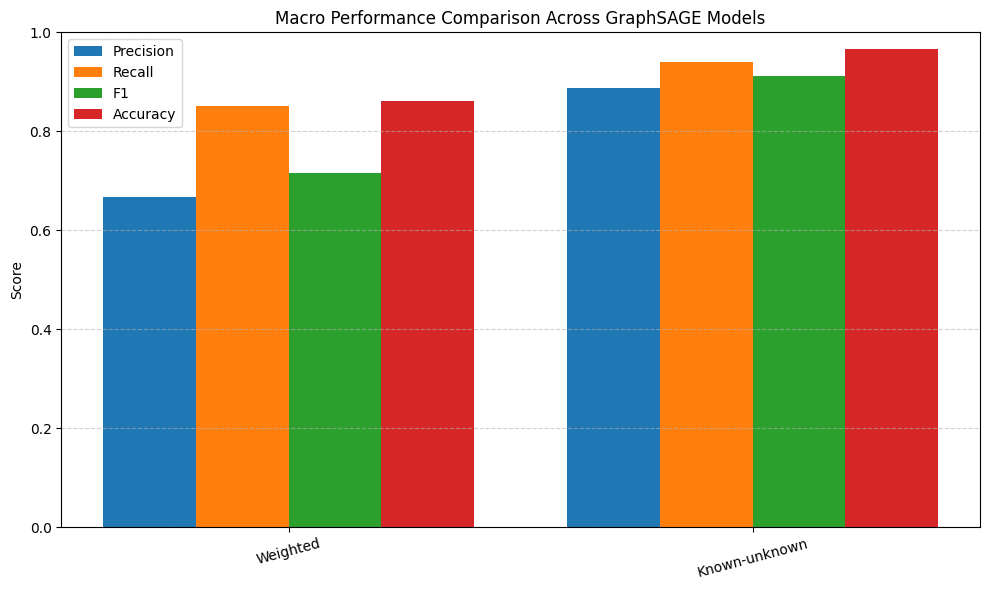

In [23]:
import matplotlib.pyplot as plt
import numpy as np

macro_metrics = ["precision", "recall", "f1", "accuracy"]
models = list(metrics_data.keys())

# Create grouped bar plot
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(10,6))

for i, metric in enumerate(macro_metrics):
    values = [metrics_data[m][metric] for m in models]
    plt.bar(x + i*width - width*1.5, values, width, label=metric.capitalize())

plt.xticks(x, models, rotation=15)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Macro Performance Comparison Across GraphSAGE Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

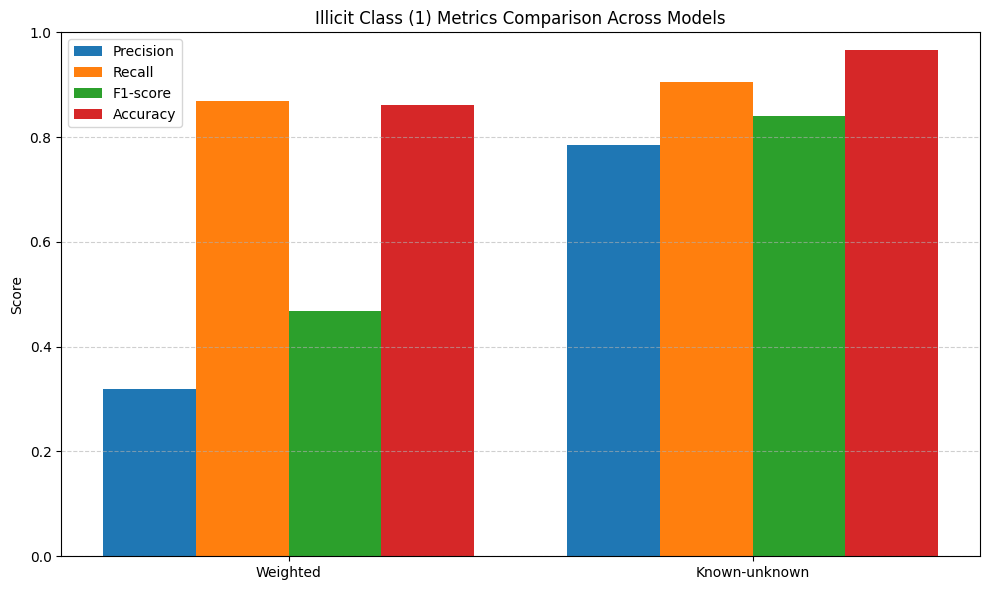

In [24]:
models = list(metrics_data.keys())
metrics_to_plot = ["precision", "recall", "f1-score", "accuracy"]

# Collect values for class 1 + overall accuracy
values_dict = {metric: [] for metric in metrics_to_plot}

for model in models:
    report = metrics_data[model]["per_class_report"]
    # Class 1 metrics
    for metric in ["precision", "recall", "f1-score"]:
        values_dict[metric].append(report.get("1", {}).get(metric, 0.0))
    # Overall accuracy
    values_dict["accuracy"].append(metrics_data[model].get("accuracy", 0.0))

# Plotting
x = np.arange(len(models))
bar_width = 0.2
plt.figure(figsize=(10,6))

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*bar_width - bar_width*1.5, values_dict[metric], width=bar_width, label=metric.capitalize())

plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Illicit Class (1) Metrics Comparison Across Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

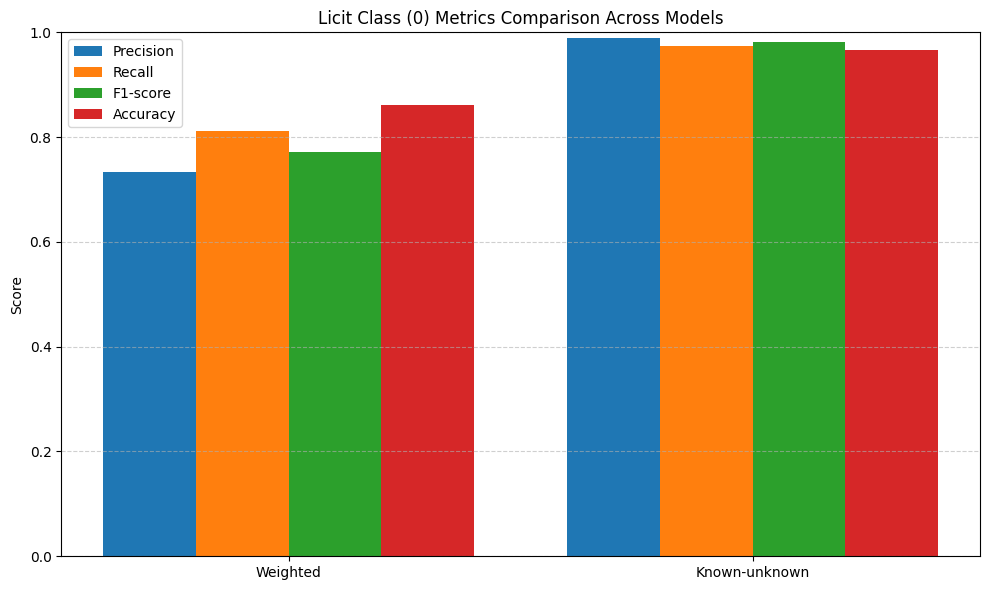

In [25]:
models = list(metrics_data.keys())
metrics_to_plot = ["precision", "recall", "f1-score", "accuracy"]

# Collect values for class 1 + overall accuracy
values_dict = {metric: [] for metric in metrics_to_plot}

for model in models:
    report = metrics_data[model]["per_class_report"]
    # Class 1 metrics
    for metric in ["precision", "recall", "f1-score"]:
        values_dict[metric].append(report.get("0", {}).get(metric, 0.0))
    # Overall accuracy
    values_dict["accuracy"].append(metrics_data[model].get("accuracy", 0.0))

# Plotting
x = np.arange(len(models))
bar_width = 0.2
plt.figure(figsize=(10,6))

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*bar_width - bar_width*1.5, values_dict[metric], width=bar_width, label=metric.capitalize())

plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Licit Class (0) Metrics Comparison Across Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()